In [155]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import stopwordsiso
import unidecode
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
cv = CountVectorizer(ngram_range=(1,1))
tv = TfidfVectorizer()

In [156]:
raw = pd.read_csv('first_mixed_data.csv', usecols=[1, 2]) 
df = pd.read_csv('first_mixed_data.csv', usecols=[1, 2])

In [157]:
df['Text'] = df['Text'].apply(lambda text: re.sub(r'(.)\1+', r'\1', re.sub(r'(.)\1{2,}', r'\1', text.lower())))

In [158]:
df = pd.concat([raw, df], axis=0)

In [159]:
df = df.sample(frac=1)

In [160]:
df['Language'].value_counts()

Oriya        30018
Bengali      29270
Malayalam    28952
Name: Language, dtype: int64

In [161]:
def preProcessing(data: pd.DataFrame):
    
    '''Returns X and y'''
    
    X = data["Text"]
    y = data["Language"]
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    with open('label_encoder_eng_ind', 'wb') as fil:
        pickle.dump(le, fil)
    
    data_list = []
    
    for text in X:
        text = re.sub(r'[!@#$(),n"%^*.?:;~`0-9]', ' ', text)
        text = re.sub(r'[[]]', ' ', text)
        text = text.lower()
        data_list.append(text)
    
    return X, y

In [162]:
x, y = preProcessing(df)

In [163]:
print('--- Preprocessing is done! ---')

--- Preprocessing is done! ---


In [164]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify=y)

In [165]:
def partialFit_predict(X, y, n_batches: int):
    
    print('--- Partial training has begun! ---')
    '''Dividing the dataset into chunks before fitting'''
    
    def batches(l, n):
        for i in range(0, len(l), n):
            yield l[i:i+n]
    
    global tv
    i = 0
    for batch in batches(range(len(X)), n_batches):
        model = MultinomialNB()
        i = i + 1
        print(i)
        
        try:
            x = tv.fit_transform(X[batch[0]:batch[-1]+1]).toarray()
            print(X.shape)
            model.partial_fit(x, y[batch[0]:batch[-1]+1], classes=np.unique(y))
        except:
            x = tv.transform(X[batch[0]:batch[-1]+1]).toarray()
            model.partial_fit(x, y[batch[0]:batch[-1]+1], classes=np.unique(y))

    print('--- Training is done! ---\n\n')
    global y_test, x_test
    x_test = tv.transform(x_test).toarray()
    
    with open('count_vectorizer_eng_ind', 'wb') as f:
        pickle.dump(tv, f)
    
    y_pred = model.predict(x_test)
    
    with open('partial_fit_model_eng_ind', 'wb') as files:
        pickle.dump(model, files)
    
    ac = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f'''Accuracy score: {ac}\n\n''', cr)
    print(sns.heatmap(cm, annot=True))

--- Partial training has begun! ---
1
(75004,)
2
(75004,)
3
(75004,)
4
(75004,)
5
(75004,)
6
(75004,)
7
(75004,)
8
(75004,)
--- Training is done! ---


Accuracy score: 0.899818676337262

               precision    recall  f1-score   support

           0       0.83      0.93      0.87      4390
           1       0.98      0.81      0.89      4343
           2       0.92      0.95      0.94      4503

    accuracy                           0.90     13236
   macro avg       0.91      0.90      0.90     13236
weighted avg       0.91      0.90      0.90     13236

AxesSubplot(0.125,0.125;0.62x0.755)


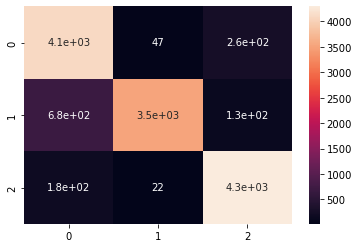

In [166]:
partialFit_predict(x_train, y_train, 10000)